In [1]:
import numpy as np
import cv2
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib as mpl
import tables
from utils import load_metadata, load_trial

## Preprocessing Functions 

Helper Functions

In [2]:
# spatially crop to non-zero area
def _spatial_crop(footstep,thresh = 10):
  img_peak = footstep.max(0)

  arr_w = np.sum(img_peak,axis=0) 
  arr_h = np.sum(img_peak,axis=1) 

  h_start = np.where(arr_h > thresh)[0][0]
  h_end = np.where(arr_h > thresh)[0][-1]
  w_start = np.where(arr_w > thresh)[0][0]
  w_end = np.where(arr_w > thresh)[0][-1]

  return(footstep[:,h_start:h_end+1,w_start:w_end+1])

# temporally crop to non-zero frames
def _temporal_crop(footstep,thresh = 10): 
    max_activation = footstep.max((1,2))

    t_start = np.where(max_activation > thresh)[0][0]
    t_end = np.where(max_activation > thresh)[0][-1]

    return footstep[t_start:t_end+1,:,:]

# zero-pad 2D image to desired width and height
def pad_image(img,w=100,h=100):
    top = np.floor((h - img.shape[0])/2)
    bottom = np.ceil((h - img.shape[0])/2)
    left = np.floor((w - img.shape[1])/2)
    right = np.ceil((w - img.shape[1])/2)

    img_padded = cv2.copyMakeBorder(img,int(top),int(bottom),int(left),int(right),cv2.BORDER_CONSTANT,value = (0,0,0))
      
    return img_padded

Spatial Normalization

In [3]:
# spatially rotate 180 degrees to make footstep upright
def spatial_flip(footstep,orientation):
  if orientation == 1:
    footstep_upright = np.flip(footstep,axis = (1,2))
  else: 
    footstep_upright = footstep
  
  return footstep_upright

# rotate centered footstep using direction of first principal component axis
def spatial_rotation(footstep):
  
  # get peak pressure image
  img_peak = footstep.max(0)

  # get angle of first principal component axis
  c, r = np.where(img_peak > 0)
  X = np.array([c,r]).T
  pca = PCA(n_components=2).fit(X)
  angle = np.arctan2(pca.components_[0,1], pca.components_[0,0])
  angle = np.degrees(angle)

  # rotate only within 90 degrees
  if abs(angle) > 90:
    angle = angle - 180 * np.sign(angle)

  rotation_angle = -angle

  # enlarge to allow room for rotation
  max_sz = max(footstep.shape[1:])
  footstep_rotated = np.zeros((footstep.shape[0],max_sz,max_sz))

  # rotate each frame and pad to desired shape
  for i,frame in enumerate(footstep):

    # rotate frame
    cX,cY = (frame.shape[1]//2, frame.shape[0]//2)
    M = cv2.getRotationMatrix2D((cX,cY),rotation_angle,1)
    frame_rotated = cv2.warpAffine(frame,M,(max_sz,max_sz),flags=cv2.INTER_NEAREST) 

    footstep_rotated[i] = frame_rotated

  # crop to footstep
  footstep_rotated = _spatial_crop(footstep_rotated)

  return footstep_rotated, rotation_angle

# center footstep based on center of mass, area, or extreme limits ('bbox') (alignment_method)
def spatial_translation(footstep,alignment_method = 'mass', thresh = 10):
    img_peak = footstep.max(0)
    w = img_peak.shape[1]
    l = img_peak.shape[0]

    if alignment_method == 'mass':
      # get center of mass
      y_center = ((img_peak.sum(1)*np.arange(0,img_peak.shape[0]))/img_peak.sum((0,1))).sum(0)
      x_center = ((img_peak.sum(0)*np.arange(0,img_peak.shape[1]))/img_peak.sum((0,1))).sum(0)
    elif alignment_method == 'area':
      # get center of area
      y_center = (((img_peak > thresh).sum(1)*np.arange(0,img_peak.shape[0]))/(img_peak > thresh).sum((0,1))).sum(0)
      x_center = (((img_peak > thresh).sum(0)*np.arange(0,img_peak.shape[1]))/(img_peak > thresh).sum((0,1))).sum(0)
    else: # 'bbox': center bounding box in frame
      y_idx = np.where((img_peak > thresh))[0] 
      x_idx = np.where((img_peak > thresh))[1]
      y_center = np.mean((y_idx.min(),y_idx.max()))
      x_center = np.mean((x_idx.min(),x_idx.max()))

    y_center = int(np.round(y_center))
    x_center = int(np.round(x_center))

    # avoid translating out of the frame 
    arr_w = np.sum(img_peak,axis=0) 
    arr_l = np.sum(img_peak,axis=1) 
    max_y_shift = min(np.where(arr_l > thresh)[0][0],l - np.where(arr_l > thresh)[0][-1]) 
    max_x_shift = min(np.where(arr_w > thresh)[0][0],w - np.where(arr_w > thresh)[0][-1])

    x_shift = w//2-x_center
    y_shift = l//2-y_center
    x_shift = np.sign(x_shift) * np.min(np.abs((x_shift,max_x_shift)))
    y_shift = np.sign(y_shift) * np.min(np.abs((y_shift,max_y_shift)))
    
    M = np.float32([
      [1, 0, x_shift],
      [0, 1, y_shift]
    ])
    footstep_centered = np.zeros(footstep.shape)  

    for i,frame in enumerate(footstep):
      frame_centered = cv2.warpAffine(frame, M, (frame.shape[1],frame.shape[0]),flags = cv2.INTER_NEAREST)
      footstep_centered[i] = frame_centered
    
    return footstep_centered

# pad footstep with zeros to specified height (h) and width (w)
def spatial_zeropad(footstep,w=100,h=100):
    footstep_padded = np.zeros((footstep.shape[0],h,w))
    top = np.floor((h - footstep.shape[1])/2)
    bottom = np.ceil((h - footstep.shape[1])/2)
    left = np.floor((w - footstep.shape[2])/2)
    right = np.ceil((w - footstep.shape[2])/2)

    for i,frame in enumerate(footstep):
      frame_padded = cv2.copyMakeBorder(frame,int(top),int(bottom),int(left),int(right),cv2.BORDER_CONSTANT,value = (0,0,0))
      footstep_padded[i] = frame_padded

    return footstep_padded

# resize sole to specified width (w_sole) and length (l_sole)
def spatial_resizing(footstep,w_sole = 25,l_sole = 70):
    
    footstep_cropped = _spatial_crop(footstep)

    # save original length and width
    length = footstep.shape[1]
    width = footstep.shape[2]

    footstep_resized = np.zeros((footstep_cropped.shape[0],l_sole,w_sole))
    for iFrame,frame in enumerate(footstep_cropped):
      footstep_resized[iFrame] = cv2.resize(frame, (w_sole,l_sole), 0, 0, interpolation = cv2.INTER_NEAREST)

    return footstep_resized, length, width

# apply an affine transformation to align the footstep to a reference template using an 
# enhanced correlation coefficient metric
def spatial_registration(footstep,template):
    img_peak = footstep.max(0).astype(np.float32)
    template = template.astype(np.float32)

    # normalize amplitudes
    img_peak = img_peak/img_peak.max()
    template = template/template.max()

    # apply affine transformation
    warp_mode = cv2.MOTION_AFFINE
    M = np.eye(2, 3, dtype=np.float32)

    # termination criteria: max 5000 iterations or 1e-10 convergence epsilon
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-10)

    # use ECC to optimize transformation parameters 
    (cc, M) = cv2.findTransformECC(template, img_peak, M, warp_mode, criteria)

    # transform each frame
    footstep_reg = np.zeros(footstep.shape)
    for iFrame,frame in enumerate(footstep):
      footstep_reg[iFrame] = cv2.warpAffine(frame, M, (frame.shape[1], frame.shape[0]),
                                    flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)

    # get corresponding transformations
    Mi = np.linalg.inv(np.concatenate((M,[[0,0,1]]),axis = 0))
    angle = np.arctan2(Mi[1,0],Mi[1,1]) * 180/np.pi
    translation_x = Mi[0,2]
    translation_y = Mi[1,2]
    scale_x = np.sign(Mi[0,0])*np.sqrt(Mi[0,0]**2 + Mi[0,1]**2)
    scale_y = np.sign(Mi[1,1])*np.sqrt(Mi[1,0]**2 + Mi[1,1]**2)

    return footstep_reg, angle, translation_x, translation_y, scale_x, scale_y

Temporal Normalization

In [4]:
# interpolate to specified number of frames (t) using a specified method (interp_method). 
# Accepted values for interp_method: ‘linear’, ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, 
# ‘quadratic’, ‘cubic’, ‘previous’, or ‘next’
def temporal_interpolation(footstep,t = 101,interp_method = 'nearest'):
    
    # crop-out inactivity at beginning and end of recording
    footstep = _temporal_crop(footstep)

    # interpolate to t frames
    f = interp1d(np.linspace(0,1,footstep.shape[0]), footstep, axis=0, kind = interp_method)
    footstep_interp = f(np.linspace(0,1,t))

    return footstep_interp

# zero-pad all footsteps to same duration (t). If the original footstep duration is longer than t, the
# function will crop the end of the footstep
def temporal_zeropad(footstep,t = 300):
    # crop-out inactivity at beginning and end of recording
    footstep = _temporal_crop(footstep)

    # get footstep size
    d, h, w = footstep.shape

    if d >= t:
        footstep_padded = footstep[0:t] # crop to t frames
    else:
        footstep_padded = np.concatenate((footstep,np.zeros((t-d,h,w))),axis = 0) # pad to t frames
    
    return footstep_padded


Amplitude Normalization

In [ ]:
# Rescale amplitude by the average total pressure of the footstep.
def amplitude_meanpressure(footstep):
    mean_pressure = footstep.sum((1,2)).mean()
    return footstep/mean_pressure, mean_pressure 

# Rescale amplitude to a minimum value of 0 and maximum of one.
def amplitude_minmax(footstep):
    return (footstep - footstep.min())/(footstep.max() - footstep.min())

# Rescale amplitude by the participant's measured body weight. 
def amplitude_bodyweight(footstep,body_mass,rx = 0.005,ry = 0.005):
    # convert body mass to N
    body_weight = body_mass * 9.81
    
    # scaling factor for converting footstep's total pressure into GRF to N
    pix_per_m2 = 1/(rx * ry)
    scale_factor = 1000/pix_per_m2
    
    return (footstep*scale_factor)/body_weight


## Load Data and Metadata

In [6]:
# Load participant metadata (needed for body weight amplitude normalization)
T_demo = pd.read_csv('participant_metadata.csv') 

In [7]:
# selected trial
participant_id = 12
shoe_type = 'BF'
walk_condition = 'W1'

In [8]:
# load raw trial data
data = load_trial(participant_id,shoe_type,walk_condition)

# load corresponding metadata
metadata = load_metadata(participant_id,shoe_type,walk_condition)

# get participant's body mass (for amplitude normalization)
body_mass = T_demo['Weight (Kg)'][T_demo['ParticipantID'] == participant_id].item() 


#### Extract Example Footstep

In [9]:
id = 39

idx = metadata['FootstepID'] == id

# get bounding box coordinates & walking direction from metadata
start_frame = metadata['StartFrame'][idx].item()
end_frame = metadata['EndFrame'][idx].item()
y_min = metadata['Ymin'][idx].item()
y_max = metadata['Ymax'][idx].item()
x_min = metadata['Xmin'][idx].item()
x_max = metadata['Xmax'][idx].item()
orientation = metadata['Orientation'][idx].item()
side = metadata['Side'][idx].item()

# extract footstep from original recording 
footstep = data[start_frame:end_frame+1,y_min:y_max+1,x_min:x_max+1].astype(np.float64)


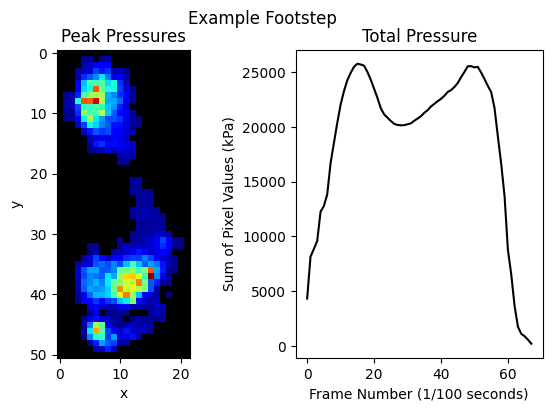

In [10]:
# create colormap (for plotting)
jet = mpl.colormaps['jet'](np.linspace(0, 1, 256))
jet[0] = [0,0,0,1]
cmap = mpl.colors.ListedColormap(jet)

# plot original footstep
fig, ax = plt.subplots(1,2,figsize = (7,4))
fig.suptitle('Example Footstep')
ax[0].imshow(footstep.max(0),cmap = cmap)
ax[0].set_title('Peak Pressures')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(footstep.sum((1,2)),'-k')
ax[1].set_title('Total Pressure')
ax[1].set_xlabel('Frame Number (1/100 seconds)')
ax[1].set_ylabel('Sum of Pixel Values (kPa)')
plt.show()

## Normalization Techniques Demo

In [11]:
h = 75 # desired height
w = 40 # desired width
t = 101 # desired duration

#### Spatial Normalization

Load Mun104 plantar pressure templates (needed for spatial registration). Available at https://github.com/0todd0000/mun104

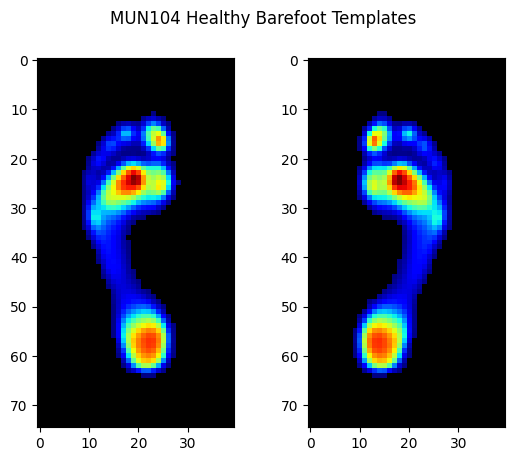

In [12]:
with tables.open_file('MUN104L.h5', 'r') as hf:
	template_L = hf.root.I.read()
# flip and zero-pad to desired size
template_L = pad_image(np.flipud(template_L),h = h, w = w).astype(np.float64)


with tables.open_file('MUN104R.h5', 'r') as hf:
	template_R = hf.root.I.read()
template_R = pad_image(np.flipud(template_R),h = h, w = w).astype(np.float64)

fig,ax = plt.subplots(1,2)
ax[0].imshow(template_L,cmap = cmap)
ax[1].imshow(template_R,cmap = cmap)
fig.suptitle('MUN104 Healthy Barefoot Templates')
plt.show()

Apply Spatial Normalization Techniques

Note: Several techniques are applied here in sequence for demonstration purposes. However, techniques may be skipped or applied in different order as needed.

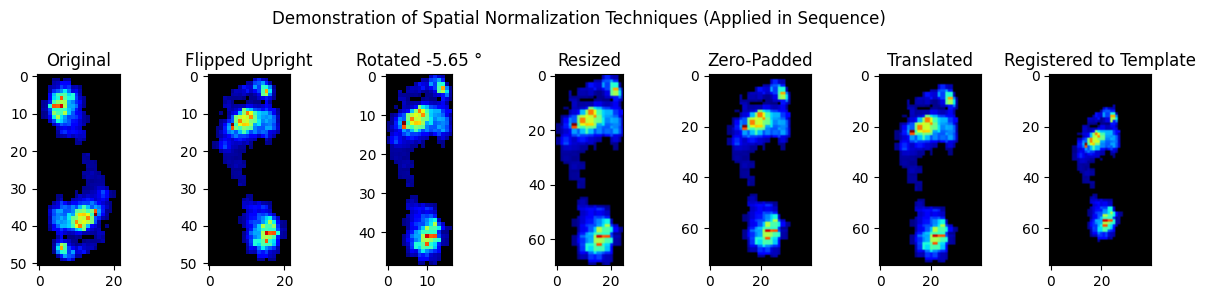

In [13]:
fig, ax = plt.subplots(1,7,figsize = (12,3), layout="tight")
fig.suptitle('Demonstration of Spatial Normalization Techniques (Applied in Sequence)')
plt.setp(ax,aspect = 'equal')
ax[0].imshow(footstep.max(0),cmap = cmap)
ax[0].set_title('Original')

# rotate footstep by 180 degrees to same orientation
footstep_flipped = spatial_flip(footstep,orientation)
ax[1].imshow(footstep_flipped.max(0),cmap = cmap)
ax[1].set_title('Flipped Upright')

# rotate according to first principal component axis
footstep_rotated,rotation_angle = spatial_rotation(footstep_flipped)
ax[2].imshow(footstep_rotated.max(0),cmap = cmap)
ax[2].set_title('Rotated ' + "{:.2f}".format(rotation_angle) + u' \N{DEGREE SIGN}')

# resize to length of 70 and width 25 pixels (should be applied after rotation)
footstep_resized,foot_length,foot_width = spatial_resizing(footstep_rotated,w_sole = 25,l_sole = 70)
ax[3].imshow(footstep_resized.max(0),cmap = cmap)
ax[3].set_title('Resized')

# zero-pad spatially to 75 x 40 pixels
footstep_padded = spatial_zeropad(footstep_resized,w = 40,h = 75)
ax[4].imshow(footstep_padded.max(0),cmap = cmap)
ax[4].set_title('Zero-Padded')

# translate footstep based on its center of mass
footstep_translated = spatial_translation(footstep_padded,alignment_method = 'mass')
ax[5].imshow(footstep_translated.max(0),cmap = cmap)
ax[5].set_title('Translated')

# apply registration to MUN104 template
if side == 'Left':
    template = template_L
else:
    template = template_R
footstep_registered, angle, translation_x, translation_y, scale_x, scale_y = spatial_registration(footstep_translated,template)
ax[6].imshow(footstep_registered.max(0),cmap = cmap)
ax[6].set_title('Registered to Template')

plt.show()


### Temporal Normalization

Apply the temporal normalization techniques to the spatially registered footstep from the previous step. 

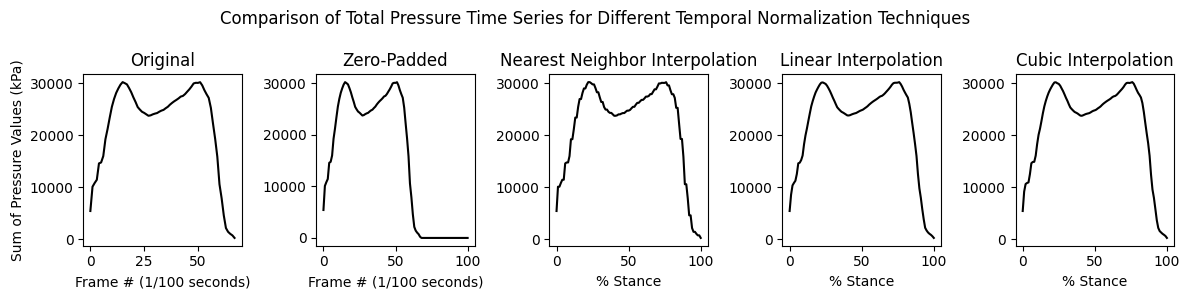

In [14]:
fig, ax = plt.subplots(1,5,figsize = (12,3), layout="tight")
fig.suptitle('Comparison of Total Pressure Time Series for Different Temporal Normalization Techniques')

ax[0].plot(footstep_registered.sum((1,2)),'k-')
ax[0].set_title('Original')
ax[0].set_xlabel('Frame # (1/100 seconds)')
ax[0].set_ylabel('Sum of Pressure Values (kPa)')

# zero-padded
footstep_zeropad = temporal_zeropad(footstep_registered,t = 101)
ax[1].plot(footstep_zeropad.sum((1,2)),'k-')
ax[1].set_title('Zero-Padded')
ax[1].set_xlabel('Frame # (1/100 seconds)')

# NN interpolation
footstep_interp_nn = temporal_interpolation(footstep_registered,t = 101,interp_method='nearest')
ax[2].plot(footstep_interp_nn.sum((1,2)),'k-')
ax[2].set_title('Nearest Neighbor Interpolation')
ax[2].set_xlabel('% Stance')

# linear interpolation
footstep_interp_lin = temporal_interpolation(footstep_registered,t = 101,interp_method='linear')
ax[3].plot(footstep_interp_lin.sum((1,2)),'k-')
ax[3].set_title('Linear Interpolation')
ax[3].set_xlabel('% Stance')

# cubic interpolation
footstep_interp_cub = temporal_interpolation(footstep_registered,t = 101,interp_method='cubic')
ax[4].plot(footstep_interp_cub.sum((1,2)),'k-')
ax[4].set_title('Cubic Interpolation')
ax[4].set_xlabel('% Stance')

plt.show()


### Amplitude Normalization

Apply the amplitude normalization techniques to the cubic-interpolated footstep from the previous step.

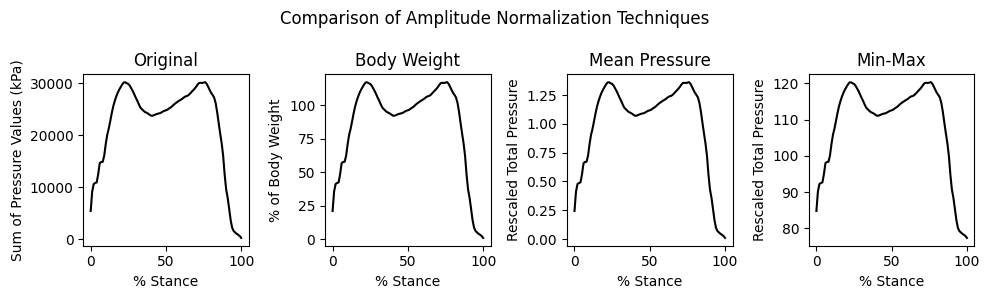

In [15]:
fig, ax = plt.subplots(1,4,figsize = (10,3), layout="tight")
fig.suptitle('Comparison of Amplitude Normalization Techniques')

ax[0].plot(footstep_interp_cub.sum((1,2)),'k-')
ax[0].set_title('Original')
ax[0].set_xlabel('% Stance')
ax[0].set_ylabel('Sum of Pressure Values (kPa)')

# body weight normalization
footstep_bw = amplitude_bodyweight(footstep_interp_cub,body_mass = body_mass)
ax[1].plot(footstep_bw.sum((1,2))*100,'k-')
ax[1].set_title('Body Weight')
ax[1].set_ylabel('% of Body Weight')
ax[1].set_xlabel('% Stance')

# Mean Pressure normalization
footstep_meanpressure,meanpressure = amplitude_meanpressure(footstep_interp_cub)
ax[2].plot(footstep_meanpressure.sum((1,2)),'k-')
ax[2].set_title('Mean Pressure')
ax[2].set_xlabel('% Stance')
ax[2].set_ylabel('Rescaled Total Pressure')

# min-max normalization
footstep_minmax = amplitude_minmax(footstep_interp_cub)
ax[3].plot(footstep_minmax.sum((1,2)),'k-')
ax[3].set_title('Min-Max')
ax[3].set_xlabel('% Stance')
ax[3].set_ylabel('Rescaled Total Pressure')

plt.show()


## Pipeline 1

Demonstration of the normalization pipeline used for processing the first provided version of the footstep data. 

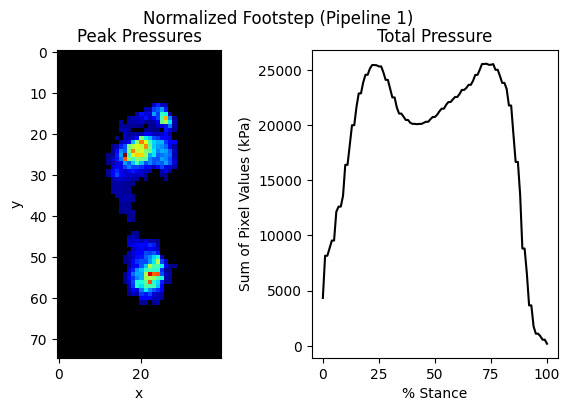

In [16]:
t = 101 # desired number of frames
h = 75 # desired height
w = 40 # desired width

######## APPLY SPATIAL NORMALIZATION ############
# rotate footsteps by 180 degrees to same orientation
footstep_flipped = spatial_flip(footstep,orientation)

# rotate according to first principal component axis
footstep_rotated,rotation_angle = spatial_rotation(footstep_flipped)

# zero-pad spatially to 75 x 40 pixels
footstep_padded = spatial_zeropad(footstep_rotated,w = 40,h = 75)

# center footstep based on its extreme limits (bounding box)
footstep_translated = spatial_translation(footstep_padded,alignment_method = 'bbox',thresh = 10)

####### APPLY TEMPORAL NORMALIZATION ############
footstep_norm = temporal_interpolation(footstep_translated)

# plot normalized footstep
fig, ax = plt.subplots(1,2,figsize = (7,4))
fig.suptitle('Normalized Footstep (Pipeline 1)')
ax[0].imshow(footstep_norm.max(0),cmap = cmap)
ax[0].set_title('Peak Pressures')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(footstep_norm.sum((1,2)),'-k')
ax[1].set_title('Total Pressure')
ax[1].set_xlabel('% Stance')
ax[1].set_ylabel('Sum of Pixel Values (kPa)')
plt.show()

## Pipeline 2

Demonstration of the normalization pipeline used for processing the second provided version of the footstep data. 

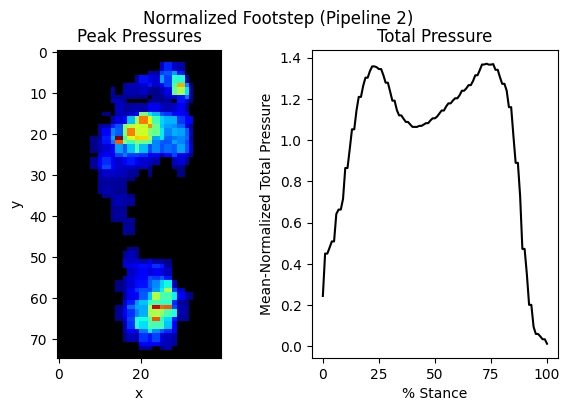

In [17]:
# extract and preprocess all footsteps in trial
t = 101 # desired number of frames
h = 75 # desired height
w = 40 # desired width
w_sole = 25
l_sole = 70

######## APPLY SPATIAL NORMALIZATION ############
# rotate footsteps by 180 degrees to same orientation
footstep_flipped = spatial_flip(footstep,orientation)

# rotate according to first principal component axis
footstep_rotated,rotation_angle = spatial_rotation(footstep_flipped)

# resize to length of 70 and width 25 pixels (should be applied after rotation)
footstep_resized,foot_length,foot_width = spatial_resizing(footstep_rotated,w_sole = w_sole,l_sole = l_sole)

# zero-pad spatially to 75 x 40 pixels
footstep_padded = spatial_zeropad(footstep_resized,w = w,h = h)

# center footstep based on its extreme limits (bounding box)
footstep_translated = spatial_translation(footstep_padded,alignment_method = 'bbox',thresh = 10)

####### APPLY TEMPORAL NORMALIZATION ############
footstep_interp = temporal_interpolation(footstep_translated,t = t)

####### APPLY AMPLITUDE NORMALIZATION ###########
footstep_norm, mean_pressure = amplitude_meanpressure(footstep_interp)

# plot normalized footstep
fig, ax = plt.subplots(1,2,figsize = (7,4))
fig.suptitle('Normalized Footstep (Pipeline 2)')
ax[0].imshow(footstep_norm.max(0),cmap = cmap)
ax[0].set_title('Peak Pressures')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(footstep_norm.sum((1,2)),'-k')
ax[1].set_title('Total Pressure')
ax[1].set_xlabel('% Stance')
ax[1].set_ylabel('Mean-Normalized Total Pressure')
plt.show()